# Exploratory Data Analysis with Python

We will explore the NYC MTA turnstile data set. These data files are from the New York Subway. It tracks the hourly entries and exits to turnstiles (UNIT) by day in the subway system.

Here is an [example of what you could do with the data](https://jameskao.me/analyzing-the-nyc-subway-dataset/). James Kao investigates how subway ridership is affected by incidence of rain.

<br>
<font color="red">
    NOTE:
    <br>
    This notebook uses code found in the
    <a href="https://github.com/TimothyHelton/k2datascience/blob/master/k2datascience/nyc_mta.py">
    <strong>k2datascience.nyc_mta</strong></a> package.
    To execute all the cells do one of the following items:
    <ul>
        <li>Install the k2datascience package to the active Python interpreter.</li>
        <li>Add k2datascience/k2datascience to the PYTHON_PATH system variable.</li>
        <li>Create a link to the nyc_mta.py file in the same directory as this notebook.</li>
</font>

---
### Imports

In [51]:
from collections import defaultdict
import csv
import os
import os.path as osp

from dateutil.parser import parse
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from k2datascience import nyc_mta

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

---
### Download Data

#### Would you like to download New York City MTA Turnstile data?
- Each file is for a week of data and is approximately 24 Megabytes in size.

In [2]:
download = False
file_quantity = 2

Scrape [MTA Turnstile Web Page](http://web.mta.info/developers/turnstile.html) to extract all available data files.

In [3]:
d = nyc_mta.TurnstileData()
if download:
    d.write_data_files(qty=file_quantity)
    print(f'\n\nThe raw data files were written out to:\n\n{d.data_dir}')

---
## Exercise 1

- Download at least 2 weeks worth of [MTA turnstile data](http://web.mta.info/developers/turnstile.html) (You can do this manually or via Python)
- Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like


        {    ('A002','R051','02-00-00','LEXINGTON AVE'):    
             [
               ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],          
                 ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],  
                ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
              ...   
         ] 
        }

*Store all the weeks in a data structure of your choosing*

### Data File Path

In [4]:
data_file = '170401.txt'
data_dir = osp.join('..', 'data', 'nyc_mta_turnstile')
data_file_path = osp.join(data_dir, data_file)

### Create Excersize 1 Dictionary

In [5]:
turnstile = defaultdict(list)
with open(data_file_path, 'r') as f:
    reader = csv.reader(f)
    initial_row = True
    for row in reader:
        if not initial_row:
            turnstile[tuple(row[:4])].append([x.strip() for x in row[4:]])
        else:
            header = [x.strip() for x in row]
            initial_row = False

#### Header

- **C/A**: Control Area (A002)
- **UNIT**: Remote Unit for a station (R051)
- **SCP**: Subunit Channel Position represents an specific address for a device (02-00-00)
- **STATION**: Represents the station name the device is located at
- **LINENAME**: Represents all train lines that can be boarded at this station
    - Normally lines are represented by one character.
    - LINENAME 456NQR represents train server for 4, 5, 6, N, Q, and R trains.


- **DIVISION**: Represents the Line originally the station belonged to BMT, IRT, or IND   
- **DATE**: Represents the date (MM-DD-YY)
- **TIME**: Represents the time (hh:mm:ss) for a scheduled audit event
- **DESc**: Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
    - Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
    - Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
    
    
- **ENTRIES**: The comulative entry register value for a device
- **EXIST**: The cumulative exit register value for a device

In [6]:
header

['C/A',
 'UNIT',
 'SCP',
 'STATION',
 'LINENAME',
 'DIVISION',
 'DATE',
 'TIME',
 'DESC',
 'ENTRIES',
 'EXITS']

#### Example Entry in Turnstile Dictionary

In [7]:
turnstile[('A002', 'R051', '02-00-00', '59 ST')][:3]

[['NQR456W',
  'BMT',
  '03/25/2017',
  '00:00:00',
  'REGULAR',
  '0006108321',
  '0002069313'],
 ['NQR456W',
  'BMT',
  '03/25/2017',
  '04:00:00',
  'REGULAR',
  '0006108343',
  '0002069319'],
 ['NQR456W',
  'BMT',
  '03/25/2017',
  '08:00:00',
  'REGULAR',
  '0006108360',
  '0002069347']]

### Create Pandas DataFrame

In [8]:
d.get_data()
d.data.shape
d.data.head()

(396013, 11)

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,00:00:00,REGULAR,6108321,2069313
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,04:00:00,REGULAR,6108343,2069319
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,08:00:00,REGULAR,6108360,2069347
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,12:00:00,REGULAR,6108462,2069456
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,16:00:00,REGULAR,6108689,2069525


---
## Exercise 2
- Let's turn this into a time series.

 For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the cumulative count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the [dateutil](https://dateutil.readthedocs.io/en/stable/) package to convert it into a datetime object.

Your new dict should look something like
 
    {    ('A002','R051','02-00-00','LEXINGTON AVE'):    
             [
                [datetime.datetime(2013, 3, 2, 3, 0), 3788],
                [datetime.datetime(2013, 3, 2, 7, 0), 2585],
                [datetime.datetime(2013, 3, 2, 12, 0), 10653],
                [datetime.datetime(2013, 3, 2, 17, 0), 11016],
                [datetime.datetime(2013, 3, 2, 23, 0), 10666],
                [datetime.datetime(2013, 3, 3, 3, 0), 10814],
                [datetime.datetime(2013, 3, 3, 7, 0), 10229],
                ...
              ],
     ....
     }



### Create Exersize 2 Time Series Dictionary

Note: The extended computational time is due to the dateutil operation.

In [9]:
turnstile_ts = {}
for k, v in turnstile.items():
    turnstile_ts[k] = [[parse(f'{x[2]} {x[3]}'), int(x[-2])] for x in v]

#### Example Entry in Turnstile Time Series Dictionary

In [10]:
turnstile_ts[('A002', 'R051', '02-00-00', '59 ST')][:10]

[[datetime.datetime(2017, 3, 25, 0, 0), 6108321],
 [datetime.datetime(2017, 3, 25, 4, 0), 6108343],
 [datetime.datetime(2017, 3, 25, 8, 0), 6108360],
 [datetime.datetime(2017, 3, 25, 12, 0), 6108462],
 [datetime.datetime(2017, 3, 25, 16, 0), 6108689],
 [datetime.datetime(2017, 3, 25, 20, 0), 6108983],
 [datetime.datetime(2017, 3, 26, 0, 0), 6109170],
 [datetime.datetime(2017, 3, 26, 4, 0), 6109213],
 [datetime.datetime(2017, 3, 26, 8, 0), 6109224],
 [datetime.datetime(2017, 3, 26, 12, 0), 6109284]]

### Add Time Stamp Series to Pandas DataFrame

In [11]:
d.get_time_stamp()
d.data.shape
d.data.head()

(396013, 12)

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,time_stamp
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,00:00:00,REGULAR,6108321,2069313,2017-03-25 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,04:00:00,REGULAR,6108343,2069319,2017-03-25 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,08:00:00,REGULAR,6108360,2069347,2017-03-25 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,12:00:00,REGULAR,6108462,2069456,2017-03-25 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2017,16:00:00,REGULAR,6108689,2069525,2017-03-25 16:00:00


---
## Exercise 3
- These counts are cumulative every n hours. We want total daily entries. 

Now make it that we again have the same keys, but now we have a single value for a single day, which is not cumulative counts but the total number of passengers that entered through this turnstile on this day.


In [12]:
daily_total = defaultdict(list)
for k, v in turnstile_ts.items():
    days = set([x[0].date() for x in v])
    for day in sorted(days):
        daily_total[k].append([day, sum([x[1] for x in v if x[0].date() == day])])

#### Example Entry in Turnstile Time Series Dictionary

In [13]:
daily_total[('A002', 'R051', '02-00-00', '59 ST')]

[[datetime.date(2017, 3, 25), 36651158],
 [datetime.date(2017, 3, 26), 36656063],
 [datetime.date(2017, 3, 27), 36660942],
 [datetime.date(2017, 3, 28), 36670134],
 [datetime.date(2017, 3, 29), 36679266],
 [datetime.date(2017, 3, 30), 36689181],
 [datetime.date(2017, 3, 31), 36698829]]

### Return Daily Entry Totals Using Pandas

In [16]:
d.daily_totals.head(20)

,c/a,unit,scp,station,date,entries
0,A002,R051,02-00-00,59 ST,2017-03-25,36651158
1,A002,R051,02-00-00,59 ST,2017-03-26,36656063
2,A002,R051,02-00-00,59 ST,2017-03-27,36660942
3,A002,R051,02-00-00,59 ST,2017-03-28,36670134
4,A002,R051,02-00-00,59 ST,2017-03-29,36679266
5,A002,R051,02-00-00,59 ST,2017-03-30,36689181
6,A002,R051,02-00-00,59 ST,2017-03-31,36698829
7,A002,R051,02-00-00,59 ST,2017-04-01,36706941
8,A002,R051,02-00-00,59 ST,2017-04-02,36712675
9,A002,R051,02-00-00,59 ST,2017-04-03,36718244


---
## Exercise 4
- We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:    

    %matplotlib inline

This will make your matplotlib graphs integrate nicely with the notebook.
To plot the time series, import matplotlib with 

    import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists:
dates and counts. This should plot it:

    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)


In [25]:
dt = d.daily_totals
dt[(dt['c/a']=='A002') &
   (dt.unit=='R051') &
   (dt.scp=='02-00-00') &
   (dt.station=='59 ST')]

,c/a,unit,scp,station,date,entries
0,A002,R051,02-00-00,59 ST,2017-03-25,36651158
1,A002,R051,02-00-00,59 ST,2017-03-26,36656063
2,A002,R051,02-00-00,59 ST,2017-03-27,36660942
3,A002,R051,02-00-00,59 ST,2017-03-28,36670134
4,A002,R051,02-00-00,59 ST,2017-03-29,36679266
5,A002,R051,02-00-00,59 ST,2017-03-30,36689181
6,A002,R051,02-00-00,59 ST,2017-03-31,36698829
7,A002,R051,02-00-00,59 ST,2017-04-01,36706941
8,A002,R051,02-00-00,59 ST,2017-04-02,36712675
9,A002,R051,02-00-00,59 ST,2017-04-03,36718244


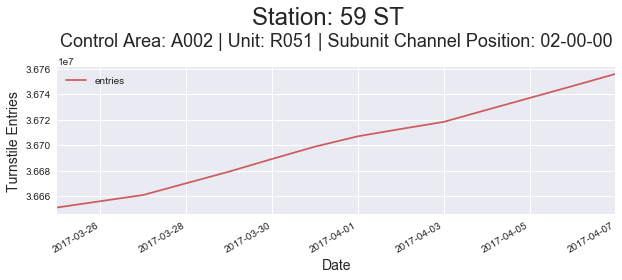

In [88]:
label_size = 14

fig = plt.figure('Station 59 ST: Daily Turnstile Entries', figsize=(10, 3),
                 facecolor='white', edgecolor='black')
ax1 = plt.subplot2grid((1, 1), (0, 0))

dt = d.daily_totals
selection = dt[(dt['c/a']=='A002') &
               (dt.unit=='R051') &
               (dt.scp=='02-00-00') &
               (dt.station=='59 ST')]
selection.plot(x='date', y='entries', color='IndianRed', ax=ax1)

plt.suptitle('Station: 59 ST', fontsize=24, y=1.16);
plt.title('Control Area: A002 | Unit: R051 | Subunit Channel Position: 02-00-00',
          fontsize=18, y=1.10);
ax1.set_xlabel('Date', fontsize=label_size)
ax1.set_ylabel('Turnstile Entries', fontsize=label_size)
fig.autofmt_xdate();

---
## Exercise 5
- So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.


---
## Exercise 6
- Similarly, combine everything in each station, and come up with a time series of `[(date1, count1),(date2,count2),...]` type of time series for each STATION, by adding up all the turnstiles in a station.

---
## Exercise 7
- Plot the time series for a station

---
## Exercise 8
- Make one list of counts for **one** week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another week.
`plt.plot(week_count_list)` for every `week_count_list` you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.



---
## Exercise 9
- Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

---
## Exercise 10
- Make a single list of these total ridership values and plot it with `plt.hist(total_ridership_counts)` to get an idea about the distribution of total ridership among different stations.   
This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

*Additional Hint*:    
If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a `plt.bar` graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be `0,1,2,3,...`, so you can do 

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

    